In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyfftw
#from src.field import _spec_variance
#from src.io import netCDFwriter


class Fluid(object):

    def __init__(self, nx, ny, Re, dt=0.0001, pad=3./2.):
        """
        initalizes the fluid, given a number or grid points in x and y. Sets flow parameters.
        Parameters:
            nx : intger
                - gird points in the x-direction
            ny : integer
                - grid points in the y-direction
            Re : float
                - Reynolds number of the flow, for very large value, set to zero
            dt : float
                - time-step, outdated as we use adaptive time-step
            pad : float
                - padding length for Jacobian evaluation
        """
        # input data
        self.nx = nx
        self.ny = ny
        self.nk = self.ny//2+1
        self.Re = Re
        self.ReI = 0.
        if self.Re != 0.:
            self.ReI = 1./self.Re
        self.dt = dt
        self.pad = pad
        self.time = 0.
        self.it = 0
        self.uptodate = False
        self.filterfac = 23.6

        self.FFTW = True
        self.fftw_num_threads = 6
        self.forced = False

        # we assume 2pi periodic domain in each dimensions
        self.x, self.dx = np.linspace(
            0, 2*np.pi, nx, endpoint=False, retstep=True)
        self.y, self.dy = np.linspace(
            0, 2*np.pi, ny, endpoint=False, retstep=True)

        # do not write by default
        self.write_enable = False

    def _wavenumber(self):
        kx = np.fft.fftfreq(self.nx, d=1./self.nx)
        ky = np.fft.fftfreq(self.ny, d=1./self.ny)
        if self.order != "spectral":
            kx = self.k_prime(kx, self.dx, self.coeffs[self.order])
            ky = self.k_prime(ky, self.dy, self.coeffs[self.order])
        return kx, ky

    def k_prime(self, kx, dx, coeffs=(1./3, 0., 14./9, 1./9, 0.)):
        alpha, beta, a, b, c = coeffs
        kp = (a * np.sin(kx*dx) + (.5*b)*np.sin(2*kx*dx) + (c/3*np.sin(3*kx*dx)))
        kp /= (1 + 2*alpha*np.cos(kx*dx) + 2*beta*np.cos(2*kx*dx)) / dx
        return kp

    def init_solver(self, order="spectral"):
        """
        Initalizes storage arrays and FFT objects. This is relatively expansive
        as pyFFTW find the fastest way to perform the transfoms, but it is only
        called once.
        """
        # numerical method
        self.order = order
        self.coeffs = {"CDS2":  (0, 0,    1,     0, 0),
                       "CDS4":  (0, 0, 4./3, -1./3, 0),
                       "Pade4": (1./4, 0, 3./2,     0, 0),
                       "Pade6": (1./3, 0, 14./9, 1./9, 0.)}

        # fourier grid
        self.kx, self.ky = self._wavenumber()
        try:
            self.k2
        except AttributeError:
            self.k2 = self.kx[:self.nk]**2 + self.ky[:, np.newaxis]**2
            self.k2I = self._empty_imag((self.nx, self.nk))
            fk = self.k2 != 0.0
            self.k2I[fk] = 1./self.k2[fk]

        # utils
        self.mx = int(self.pad * self.nx)
        self.mk = int(self.pad * self.nk)
        self.my = int(self.pad * self.ny)

        # for easier slicing when padding
        self.padder = np.ones(self.mx, dtype=bool)
        self.padder[int(self.nx/2):int(self.nx*(self.pad-0.5)):] = False

        # initialise array required for solving
        self.u = self._empty_real()
        self.v = self._empty_real()
        self.w = self._empty_real()
        self.f = self._empty_real()

        self.uh = self._empty_imag()
        self.vh = self._empty_imag()
        self.wh0 = self._empty_imag()
        self.wh = self._empty_imag()
        self.fh = self._empty_imag()
        self.psih = self._empty_imag()
        self.dwhdt = self._empty_imag()

        # assign padded arrays for non-linear term
        self.a = self._empty_imag((self.mx, self.mk))
        self.a1 = self._empty_imag((self.mx, self.mk))
        self.a2 = self._empty_imag((self.mx, self.mk))
        self.a3 = self._empty_imag((self.mx, self.mk))
        self.a4 = self._empty_imag((self.mx, self.mk))

        self.b = self._empty_real((self.mx, self.my))
        self.b1 = self._empty_real((self.mx, self.my))
        self.b2 = self._empty_real((self.mx, self.my))
        self.b3 = self._empty_real((self.mx, self.my))
        self.b4 = self._empty_real((self.mx, self.my))

        # for fast transform
        # pyfftw.interfaces.cache.enable()
        pyfftw.config.NUM_THREADS = self.fftw_num_threads
        pyfftw.config.PLANNER_EFFORT = 'FFTW_MEASURE'

        self.w_to_wh = pyfftw.FFTW(self.w,  self.wh, threads=self.fftw_num_threads,
                                   axes=(-2, -1))
        self.wh_to_w = pyfftw.FFTW(self.wh,  self.w, threads=self.fftw_num_threads,
                                   direction='FFTW_BACKWARD', axes=(-2, -1))
        self.u_to_uh = pyfftw.FFTW(self.u,  self.uh, threads=self.fftw_num_threads,
                                   axes=(-2, -1))
        self.uh_to_u = pyfftw.FFTW(self.uh, self.u, threads=self.fftw_num_threads,
                                   direction='FFTW_BACKWARD', axes=(-2, -1))
        self.v_to_vh = pyfftw.FFTW(self.v,  self.vh, threads=self.fftw_num_threads,
                                   axes=(-2, -1))
        self.f_to_fh = pyfftw.FFTW(self.f,  self.fh, threads=self.fftw_num_threads,
                                   axes=(-2, -1))
        self.vh_to_v = pyfftw.FFTW(self.vh, self.v, threads=self.fftw_num_threads,
                                   direction='FFTW_BACKWARD', axes=(-2, -1))
        self.b_to_a = pyfftw.FFTW(self.b, self.a, threads=self.fftw_num_threads,
                                  axes=(-2, -1))
        self.a1_to_b1 = pyfftw.FFTW(self.a1, self.b1, threads=self.fftw_num_threads,
                                    direction='FFTW_BACKWARD', axes=(-2, -1))
        self.a2_to_b2 = pyfftw.FFTW(self.a2, self.b2, threads=self.fftw_num_threads,
                                    direction='FFTW_BACKWARD', axes=(-2, -1))
        self.a3_to_b3 = pyfftw.FFTW(self.a3, self.b3, threads=self.fftw_num_threads,
                                    direction='FFTW_BACKWARD', axes=(-2, -1))
        self.a4_to_b4 = pyfftw.FFTW(self.a4, self.b4, threads=self.fftw_num_threads,
                                    direction='FFTW_BACKWARD', axes=(-2, -1))

        # ṣpectral filter
        try:
            self.fltr
        except AttributeError:
            self._init_filter()

    def init_field(self, func, **kwargs):
        """
        Inital the vorticity field. 
            Params:
                field : a function that return the desired field
                    prototype function is : f(x, y, Re, *kwargs)
        """
        if not callable(func):
            raise "Error: func must be callable, prototype function is : f(x, y, Re, *kwargs)"
        self.w[:, :] = func(self.x, self.y, self.Re, **kwargs)
        self.w_to_wh()

    # bit-aligned storage arrays for pyFFTW
    def _empty_real(self, *args):
        shape = (self.nx, self.ny)
        for sp in args:
            shape = sp
        if self.FFTW:
            out = pyfftw.empty_aligned(shape, dtype='float64')
            out.flat[:] = 0.
            return out
        else:
            return np.zeros(shape, dtype='float64')

    def _empty_imag(self, *args):
        shape = (self.nx, self.nk)
        for sp in args:
            shape = sp
        if self.FFTW:
            out = pyfftw.empty_aligned(shape, dtype='complex128')
            out.flat[:] = 0. + 0.*1j
            return out
        else:
            return np.zeros(shape, dtype='complex128')

    def get_u(self):
        self.uh[:, :] = 1j*self.ky[:, np.newaxis]*self.psih[:, :]
        self.uh_to_u()

    def get_v(self):
        self.vh[:, :] = -1j*self.kx[:self.nk]*self.psih[:, :]
        self.vh_to_v()

    def _init_filter(self):
        """
        Exponential filter, designed to completely dampens higest modes to machine accuracy
        """
        cphi = 0.65*np.max(self.kx)
        wvx = np.sqrt(self.k2)
        filtr = np.exp(-self.filterfac*(wvx-cphi)**4.)
        filtr[wvx <= cphi] = 1.
        self.fltr = filtr

    def _cfl_limit(self):
        """
        Adjust time-step based on the courant condition
        """
        self.get_u()
        self.get_v()
        Dc = np.max(np.pi*((1.+abs(self.u))/self.dx +
                           (1.+abs(self.v))/self.dy))
        Dmu = np.max(np.pi**2*(self.dx**(-2) + self.dy**(-2)))
        self.dt = np.sqrt(3.) / (Dc + Dmu)

    def _init_forcing(self, f):
        if callable(f):
            self.func = f
            self.forced = True

    def _add_forcing(self):
        self.f[:, :] = self.func(self.x, self.y)
        self.f_to_fh()

    def update(self, s=3):
        """
        Hybrid implicit-explicit total variational diminishing Runge-Kutta 3rd-order 
        from Gottlieb and Shu (1998) or low-storage S-order Runge-Kutta method from
        Jameson, Schmidt and Turkel (1981).
        Input:
            s : float
                - desired order of the method, default is 3rd order
        """
        # iniitalise field
        if self.forced:
            self._add_forcing()
        self.wh0[:, :] = self.wh[:, :] + self.fh[:, :]

        for k in range(s, 0, -1):
            # for t, v, d in zip([1.,.75,1./3.],[0.,.25,2./3.],[1.,.25,2./3.]):
            # invert Poisson equation for the stream function (changes to k-space)
            self._get_psih()

            # get convective forces (resets dwhdt)
            self._add_convection()

            # add diffusion
            self._add_diffusion()

            # step in time
            self.wh[:, :] = self.wh0[:, :] + (self.dt/k) * self.dwhdt[:, :]
            # self.w[:, :] = (t*self.w0[:, :] + v*self.w[:, :] + d*self.dt*self.dwdt[:, :])

        self.time += self.dt
        self._cfl_limit()
        self.it += 1

    def _get_psih(self):
        """
        Spectral stream-function from spectral vorticity
            psi = omega / (k_x^2 + k_y^2)
        """
        self.psih[:, :] = self.wh[:, :] * self.k2I[:, :]

    def _add_convection(self):
        """
        Convective term
            d/dx psi * d/dy omega - d/dy psi * d/dx omega
        To prevent alliasing, we zero-pad the array before using the
        convolution theorem to evaluate it in physical space.

        Note: this resets dwhdt when called
        """
        # padded arrays
        j1f_padded = np.zeros((self.mx, self.mk), dtype='complex128')
        j2f_padded = np.zeros((self.mx, self.mk), dtype='complex128')
        j3f_padded = np.zeros((self.mx, self.mk), dtype='complex128')
        j4f_padded = np.zeros((self.mx, self.mk), dtype='complex128')

        j1f_padded[self.padder, :self.nk] = 1.0j * \
            self.kx[:self.nk]*self.psih[:, :]
        j2f_padded[self.padder, :self.nk] = 1.0j * \
            self.ky[:, np.newaxis]*self.wh[:, :]
        j3f_padded[self.padder, :self.nk] = 1.0j * \
            self.ky[:, np.newaxis]*self.psih[:, :]
        j4f_padded[self.padder, :self.nk] = 1.0j * \
            self.kx[:self.nk]*self.wh[:, :]

        # ifft
        j1 = self.a1_to_b1(j1f_padded)
        j2 = self.a2_to_b2(j2f_padded)
        j3 = self.a3_to_b3(j3f_padded)
        j4 = self.a4_to_b4(j4f_padded)

        jacp = j1*j2 - j3*j4

        jacpf = self.b_to_a(jacp)

        self.dwhdt[:, :] = jacpf[self.padder, :self.nk] * \
            self.pad**(2)  # this term is the result of padding

    def _add_diffusion(self):
        """
        Diffusion term of the Navier-Stokes
            1/Re * (-k_x^2 -k_y^2) * omega
        """
        self.dwhdt[:, :] = self.dwhdt[:, :] - self.ReI*self.k2*self.wh[:, :]

    def _add_spec_filter(self):
        self.dwhdt *= self.fltr

    def tke(self):
        ke = .5*_spec_variance(np.sqrt(self.k2)*self.psih)
        return ke.sum()

    def enstrophy(self):
        wh = self.wh[:, :]
        w = np.fft.irfft2(wh, axes=(-2, -1))
        eps = .5*abs(w)**2
        return eps.sum(axis=(-2, -1))

    def _compute_spectrum(self, res):
        self._get_psih()
        # angle averaged TKE spectrum
        tke = np.real(.5*self.k2*self.psih*np.conj(self.psih))
        kmod = np.sqrt(self.k2)
        # nyquist limit for this grid
        self.k = np.arange(1, self.nk, 1, dtype=np.float64)
        self.E = np.zeros_like(self.k)
        dk = (np.max(self.k)-np.min(self.k))/res

        #  binning energies with wavenumber modulus in threshold
        for i in range(len(self.k)):
            self.E[i] += np.sum(tke[(kmod < self.k[i]+dk)
                                    & (kmod >= self.k[i]-dk)])

    def plot_spec(self, res=200):
        self._compute_spectrum(200)
        plt.figure(figsize=(6, 6))
        plt.loglog(self.k, self.E, '-k', label="E(k)")
        plt.xlabel("k")
        plt.ylabel("E(k)")
        plt.legend()
        plt.show()

    def write(self, file):
        if(not self.write_enable):
            self.init_writer(file)
        self.writer.add(self)

    def init_writer(self, name):
        self.writer = netCDFwriter(name, self)
        self.write_enable = True

    def display(self, complex=False, u_e=None):
        u = self.w
        if complex:
            u = np.real(self.wh)
        if not np.any(u_e) == None:
            u -= u_e
        p = plt.imshow(u, cmap="RdBu_r")
        plt.colorbar(p)
        # plt.xticks([]); plt.yticks([])
        plt.show()

    def display_vel(self):
        # if(self.uptodate!=True):
        self.w_to_wh()
        self._get_psih()
        self.get_u()
        self.get_v()
        plt.figure()
        plt.streamplot(self.x, self.y, self.u, self.v)
        plt.xlabel("x")
        plt.ylabel("y")
        plt.show()

    def run_live(self, stop, every=100):
        from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
        plt.ion()
        fig = plt.figure()
        ax = fig.add_subplot(111)
        im = ax.imshow(np.fft.irfft2(self.wh, axes=(-2, -1)),
                       norm=None, cmap="RdBu")
        cax = make_axes_locatable(ax).append_axes("right", size="5%", pad="2%")
        cb = fig.colorbar(im, cax=cax)
        ax.set_xticks([])
        ax.set_yticks([])
        while(self.time <= stop):
            #  update using RK
            self.update()
            if(self.it % every == 0):
                im.set_data(np.fft.irfft2(self.wh, axes=(-2, -1)))
                fig.canvas.draw()
                fig.canvas.flush_events()
                plt.pause(1e-9)
                print("Iteration \t %d, time \t %f, time remaining \t %f. TKE: %f" % (self.it,
                                                                                      self.time, stop-self.time, self.tke()))


In [2]:
import numpy as np
import math


def L2(v): return np.sqrt(1./np.dot(*v.shape)
                          * np.einsum('ij->', (np.abs(v))**2))


def Linf(v): return np.max(np.abs(v))


def _spec_variance(ph):
    # only half the spectrum for real ffts, needs spectral normalisation
    nx, nk = ph.shape
    ny = (nk-1)*2
    var_dens = 2 * np.abs(ph)**2 / (nx*ny)**2
    # only half of coefs [0] and [nx/2+1] due to symmetry in real fft2
    var_dens[..., 0] /= 2.
    var_dens[..., -1] /= 2.

    return var_dens.sum(axis=(-2, -1))


def Curl(u, v, dx, dy):
    curl = np.zeros_like(u)
    curl[1:-1, 1:-1] = (u[1:-1, 2:]-u[1:-1, :-2])/dy - \
        ((v[2:, 1:-1]-v[:-2, 1:-1])/dx)
    return curl


def FromDat(x, y, Re, **kwargs):
    field = np.genfromtxt(kwargs.get('name', 1.))[1:, :]
    if(type(field) == np.ndarray):
        if(field.shape == (len(x), len(y))):
            return field
        else:
            print("Specified velocity field does not match grid initialized.")


def TaylorGreen(x, y, Re, **kwargs):
    kappa = kwargs.get('kappa', 1.)
    t = kwargs.get('time', 0.)
    field = 2 * kappa * np.cos(kappa * x) * np.cos(kappa * y[:, np.newaxis]) *\
        np.exp(-2 * kappa**2 * t / Re)
    return field


def ShearLayer(x, y, Re, **kwargs):
    delta = kwargs.get('delta', 0.005)
    sigma = kwargs.get('sigma', 15./np.pi)
    field = delta * np.cos(x) - sigma * np.cosh(sigma * (y[:, np.newaxis] -
                                                         0.5*np.pi))**(-2)
    field += delta * np.cos(x) + sigma * np.cosh(sigma * (1.5*np.pi -
                                                          y[:, np.newaxis]))**(-2)
    return field


def ConvectiveVortex(x, y, Re, **kwargs):
    Uinf = kwargs.get('Uinf', 1.)
    beta = kwargs.get('beta', 1./50.)
    R = kwargs.get('R', 0.005*np.pi)
    dx = x[1]-x[0]
    dy = y[1]-y[0]
    # radial distance to vortex core
    rx = x - np.pi
    ry = y[:, np.newaxis]-np.pi
    r = np.sqrt(rx**2+ry**2)

    # init field
    # u = Uinf*(1-beta*(y[:,np.newaxis]-np.pi)/R*np.exp(-r**2/2))
    # v = Uinf*beta*(x-np.pi)/R*np.exp(-r**2/2)
    beta = 5.
    u = Uinf-beta/(2*np.pi)*np.exp(0.5*(1-r**2))*ry
    v = Uinf+beta/(2*np.pi)*np.exp(0.5*(1-r**2))*rx
    return Curl(u, v, dx, dy)


def McWilliams(x, y, Re, **kwargs):
    """
    Generates McWilliams vorticity field, see:
        McWilliams (1984), "The emergence of isolated coherent vortices in turbulent flow"
    """
    # Fourier mesh
    nx = len(x)
    kx = np.fft.fftfreq(nx, d=1./nx)
    ny = len(y)
    ky = np.fft.fftfreq(ny, d=1./ny)
    nk = ny//2+1

    # generate variable
    k2 = kx[:nk]**2 + ky[:, np.newaxis]**2
    fk = k2 != 0.0

    # ensemble variance proportional to the prescribed scalar wavenumber function
    ck = np.zeros((nx, nk))
    ck[fk] = (np.sqrt(k2[fk])*(1+(k2[fk]/36)**2))**(-1)

    # Gaussian random realization for each of the Fourier components of psi
    psih = np.random.randn(nx, nk)*ck +\
        1j*np.random.randn(nx, nk)*ck

    # ṃake sure the stream function has zero mean
    cphi = 0.65*np.max(kx)
    wvx = np.sqrt(k2)
    filtr = np.exp(-23.6*(wvx-cphi)**4.)
    filtr[wvx <= cphi] = 1.
    KEaux = _spec_variance(filtr*np.sqrt(k2)*psih)
    psi = psih/np.sqrt(KEaux)

    # inverse Laplacian in k-space
    wh = k2 * psi

    # vorticity in physical space
    field = np.fft.irfft2(wh)
    return field


def EnergySpectrum(k, s=3, kp=12):

    # normalise the spectrum
    a_s = (2*s + 1)**(s + 1) / (2**s * math.factorial(s))

    # compute sectrum at this wave number
    E = a_s / (2 * kp) * (k / kp)**(2*s + 1) * np.exp(-(s + 0.5) * (k / kp)**2)

    return E


def PhaseFunction(kx, ky):

    # half the array size
    lenx2 = len(kx)//2
    leny2 = len(ky)//2

    # define phase array
    xi = np.zeros((len(kx), len(ky)))

    # compute phase field in k space, need more points because of how
    # python organises wavenumbers
    zeta = 2 * np.pi * np.random.rand(lenx2+1, leny2+1)
    eta = 2 * np.pi * np.random.rand(lenx2+1, leny2+1)

    # quadrant \xi(kx,ky) = \zeta(kx,ky) + \eta(kx,ky)
    xi[:lenx2, :leny2] = zeta[:-1, :-1] + eta[:-1, :-1]

    # quadrant \xi(-kx,ky) = -\zeta(kx,ky) + \eta(kx,ky)
    xi[lenx2:, :leny2] = np.flip(-zeta[1:, :-1] + eta[1:, :-1], 0)

    # quadrant \xi(-kx,-ky) = -\zeta(kx,ky) - \eta(kx,ky)
    xi[lenx2:, leny2:] = np.flip(-zeta[1:, 1:] - eta[1:, 1:])

    # quadrant \xi(kx,-ky) = \zeta(kx,ky) - \eta(kx,ky)
    xi[:lenx2, leny2:] = np.flip(zeta[:-1, 1:] - eta[:-1, 1:], 1)

    return np.exp(1j * xi)


def DecayingTurbulence(x, y, Re, **kwargs):
    """
    Generates random vorticity field, see:
        Omer San, Anne E. Staples : High-order methods for decaying two-dimensional homogeneous isotropic turbulence
    """
    # Fourier mesh
    nx = len(x)
    kx = np.fft.fftfreq(nx, d=1./nx)
    ny = len(y)
    ky = np.fft.fftfreq(ny, d=1./ny)

    # define 2D spectrum array
    w_hat = np.empty((len(kx), len(ky)), dtype=np.complex128)

    # compute vorticity field in k space
    k = np.sqrt(kx**2 + ky[:, np.newaxis]**2)
    w_hat = np.sqrt((k / np.pi) * EnergySpectrum(k))

    # add random phase
    whatk = w_hat * PhaseFunction(kx, ky)

    # transforms initial field in physical space
    w = np.fft.ifft2(whatk) * nx * ny

    return np.real(w)


In [3]:
import time as t
import numpy as np
#from src.fluid import Fluid
#from src.field import TaylorGreen,L2,Linf

if __name__ == "__main__":

    # build fluid and solver
    flow = Fluid(128, 128, 1.)
    flow.init_solver()
    flow.init_field(TaylorGreen)

    print("Starting integration on field.\n")
    start_time = t.time()
    finish = 0.1

    # loop to solve
    while(flow.time <= finish):

        #  update using RK
        flow.update()

        #  print every 100 iterations
        if (flow.it % 100 == 0):
            print("Iteration \t %d, time \t %f, time remaining \t %f. TKE: %f, ENS: %f" % (flow.it,
                                                                                           flow.time, finish-flow.time, flow.tke(), flow.enstrophy()))
    # flow.run_live(finish, every=100)

    end_time = t.time()
    print("\nExecution time for %d iterations is %f seconds." %
          (flow.it, end_time-start_time))

    # get final results
    flow.wh_to_w()
    w_n = flow.w.copy()

    # exact solution
    w_e = TaylorGreen(flow.x, flow.y, flow.Re, time=flow.time)

    # L2-norm and exit
    print("The L2-norm of the Error in the Taylor-Green vortex on a %dx%d grid is %e." %
          (flow.nx, flow.ny, L2(w_e - w_n)))
    print("The Linf-norm of the Error in the Taylor-Green vortex on a %dx%d grid is %e." %
          (flow.nx, flow.ny, Linf(w_e - w_n)))


Starting integration on field.

Iteration 	 100, time 	 0.020556, time remaining 	 0.079444. TKE: 0.230362, ENS: 7545.383675
Iteration 	 200, time 	 0.041224, time remaining 	 0.058776. TKE: 0.212083, ENS: 6946.670009
Iteration 	 300, time 	 0.061898, time remaining 	 0.038102. TKE: 0.195250, ENS: 6395.309422
Iteration 	 400, time 	 0.082578, time remaining 	 0.017422. TKE: 0.179749, ENS: 5887.574573

Execution time for 485 iterations is 4.208362 seconds.
The L2-norm of the Error in the Taylor-Green vortex on a 128x128 grid is 4.830194e-13.
The Linf-norm of the Error in the Taylor-Green vortex on a 128x128 grid is 9.661161e-13.


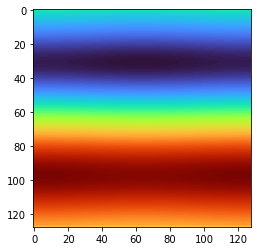

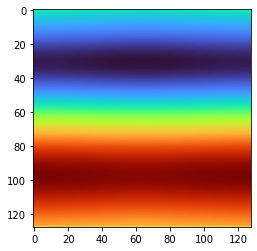

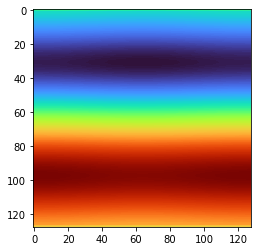

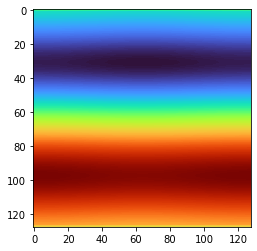

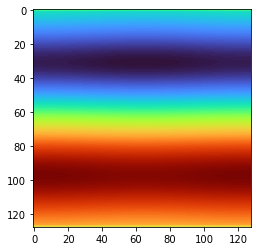

KeyboardInterrupt: 

In [27]:
%matplotlib inline
# build fluid and solver
flow = Fluid(128,128, 150)
flow.init_solver()
flow.init_field(ShearLayer, sigma=0.7)
stop = 1
every = 100
j = 0
u = []
for i in range(10000):
    #  update using RK
    flow.update()
    if(flow.it % every == 0):
        # flow.display()
        u.append(np.fft.irfft2(flow.wh, axes=(-2, -1)))
        
        plt.imshow(u[j], cmap="turbo")
        j += 1
        """print("Iteration \t %d, time \t %f, time remaining \t %f. TKE: %f" %(flow.it,
                      flow.time, stop-flow.time, flow.tke()))"""
        plt.show()
        #flow.wh_to_w()
        #u = flow.w
        """if complex:
            u = np.real(flow.wh)
        if not np.any(u_e) == None:
            u -= u_e"""
        """p = plt.imshow(u, cmap="RdBu_r")
        plt.colorbar(p)
        # plt.xticks([]); plt.yticks([])
        plt.show()"""


In [21]:
import matplotlib.animation as animation
%matplotlib tk
def plot_fluid(u_k):
    # Clear the current plot figure
    plt.clf()

    plt.title(f"Navier-Stokes-Equation")
    plt.xlabel("x")
    plt.ylabel("y")

    # This is to plot u_k (u at time-step k)
    plt.imshow(u_k, cmap="Spectral")#, vmin=300, vmax=1000)
    plt.colorbar()

    return plt

def animate(k):
    plt_ = plot_fluid(u[k])
    return plt_,

anim = animation.FuncAnimation(plt.figure(), animate, interval=1, 
                               frames=len(u))
anim.save("navier_stokes.gif")

MovieWriter ffmpeg unavailable; using Pillow instead.
